In [1]:
import os

try:
    has_changed_dir
except:
    has_changed_dir = False

try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
except:
    IN_COLAB = False

if IN_COLAB:
    %pip install datasets
    %pip install translate-toolkit
    %pip install fasttext

    !git clone https://github.com/MartinKirkegaardDK/KDS_MI.git

    if not has_changed_dir:
        os.chdir('KDS_MI')
        has_changed_dir = True
else:
    if not has_changed_dir:
        os.chdir('.')
        has_changed_dir = True

In [2]:
%load_ext autoreload
%autoreload 2

## Settings

In [ ]:
# whether to compute or just plot

compute = False

# which model to use

model_name="downloaded_models/gpt_gptsw3_en_da_is_356m_gbs1024"
model_name = "EleutherAI/pythia-14m"
model_name = "AI-Sweden-Models/gpt-sw3-356m"

# which device

device = "cuda"

# which hook points

hook_points = ["layernorm_1-pre","attention-pre","attention-post","layernorm_2-pre","mlp-pre","mlp-post"]


# which languages to run

all_languages = ["nb","is","da","en","sv"]

not_target_languages = []
target = "da"

if "download" in model_name:
    model_name_temp = model_name.split("/")[-1]
    for split in model_name.split("_"):
        if (split in all_languages) and (split !=target):
            not_target_languages.append(split)
else:
    
    model_name_temp = model_name.split("/")[-1]
    model_name_temp = model_name_temp.replace("-","_")
    not_target_languages = [lang for lang in all_languages if lang != target]











In [4]:
from src import (
    preprocessing,
    PCA,
    probe_confidence_intervals,
    plot_probes,
    make_steering_vectors,
    distance_plots,
    steering_loss,
    create_bible_data,
    process_bible_data,
    visualize_bible_study,
    scandeval_results,
    create_neuron_contributions,
    plot_outlier_neurons,
    text_visualization,
    logit_lens
)

from src.utils.new.data import load_bible_data

from transformers import AutoModelForCausalLM, AutoTokenizer

## Preprocessing

In [5]:
if compute:
    preprocessing.run()

## Representation Identification

### Principal Component Analysis

  8%|▊         | 11/130 [00:36<06:35,  3.33s/it]


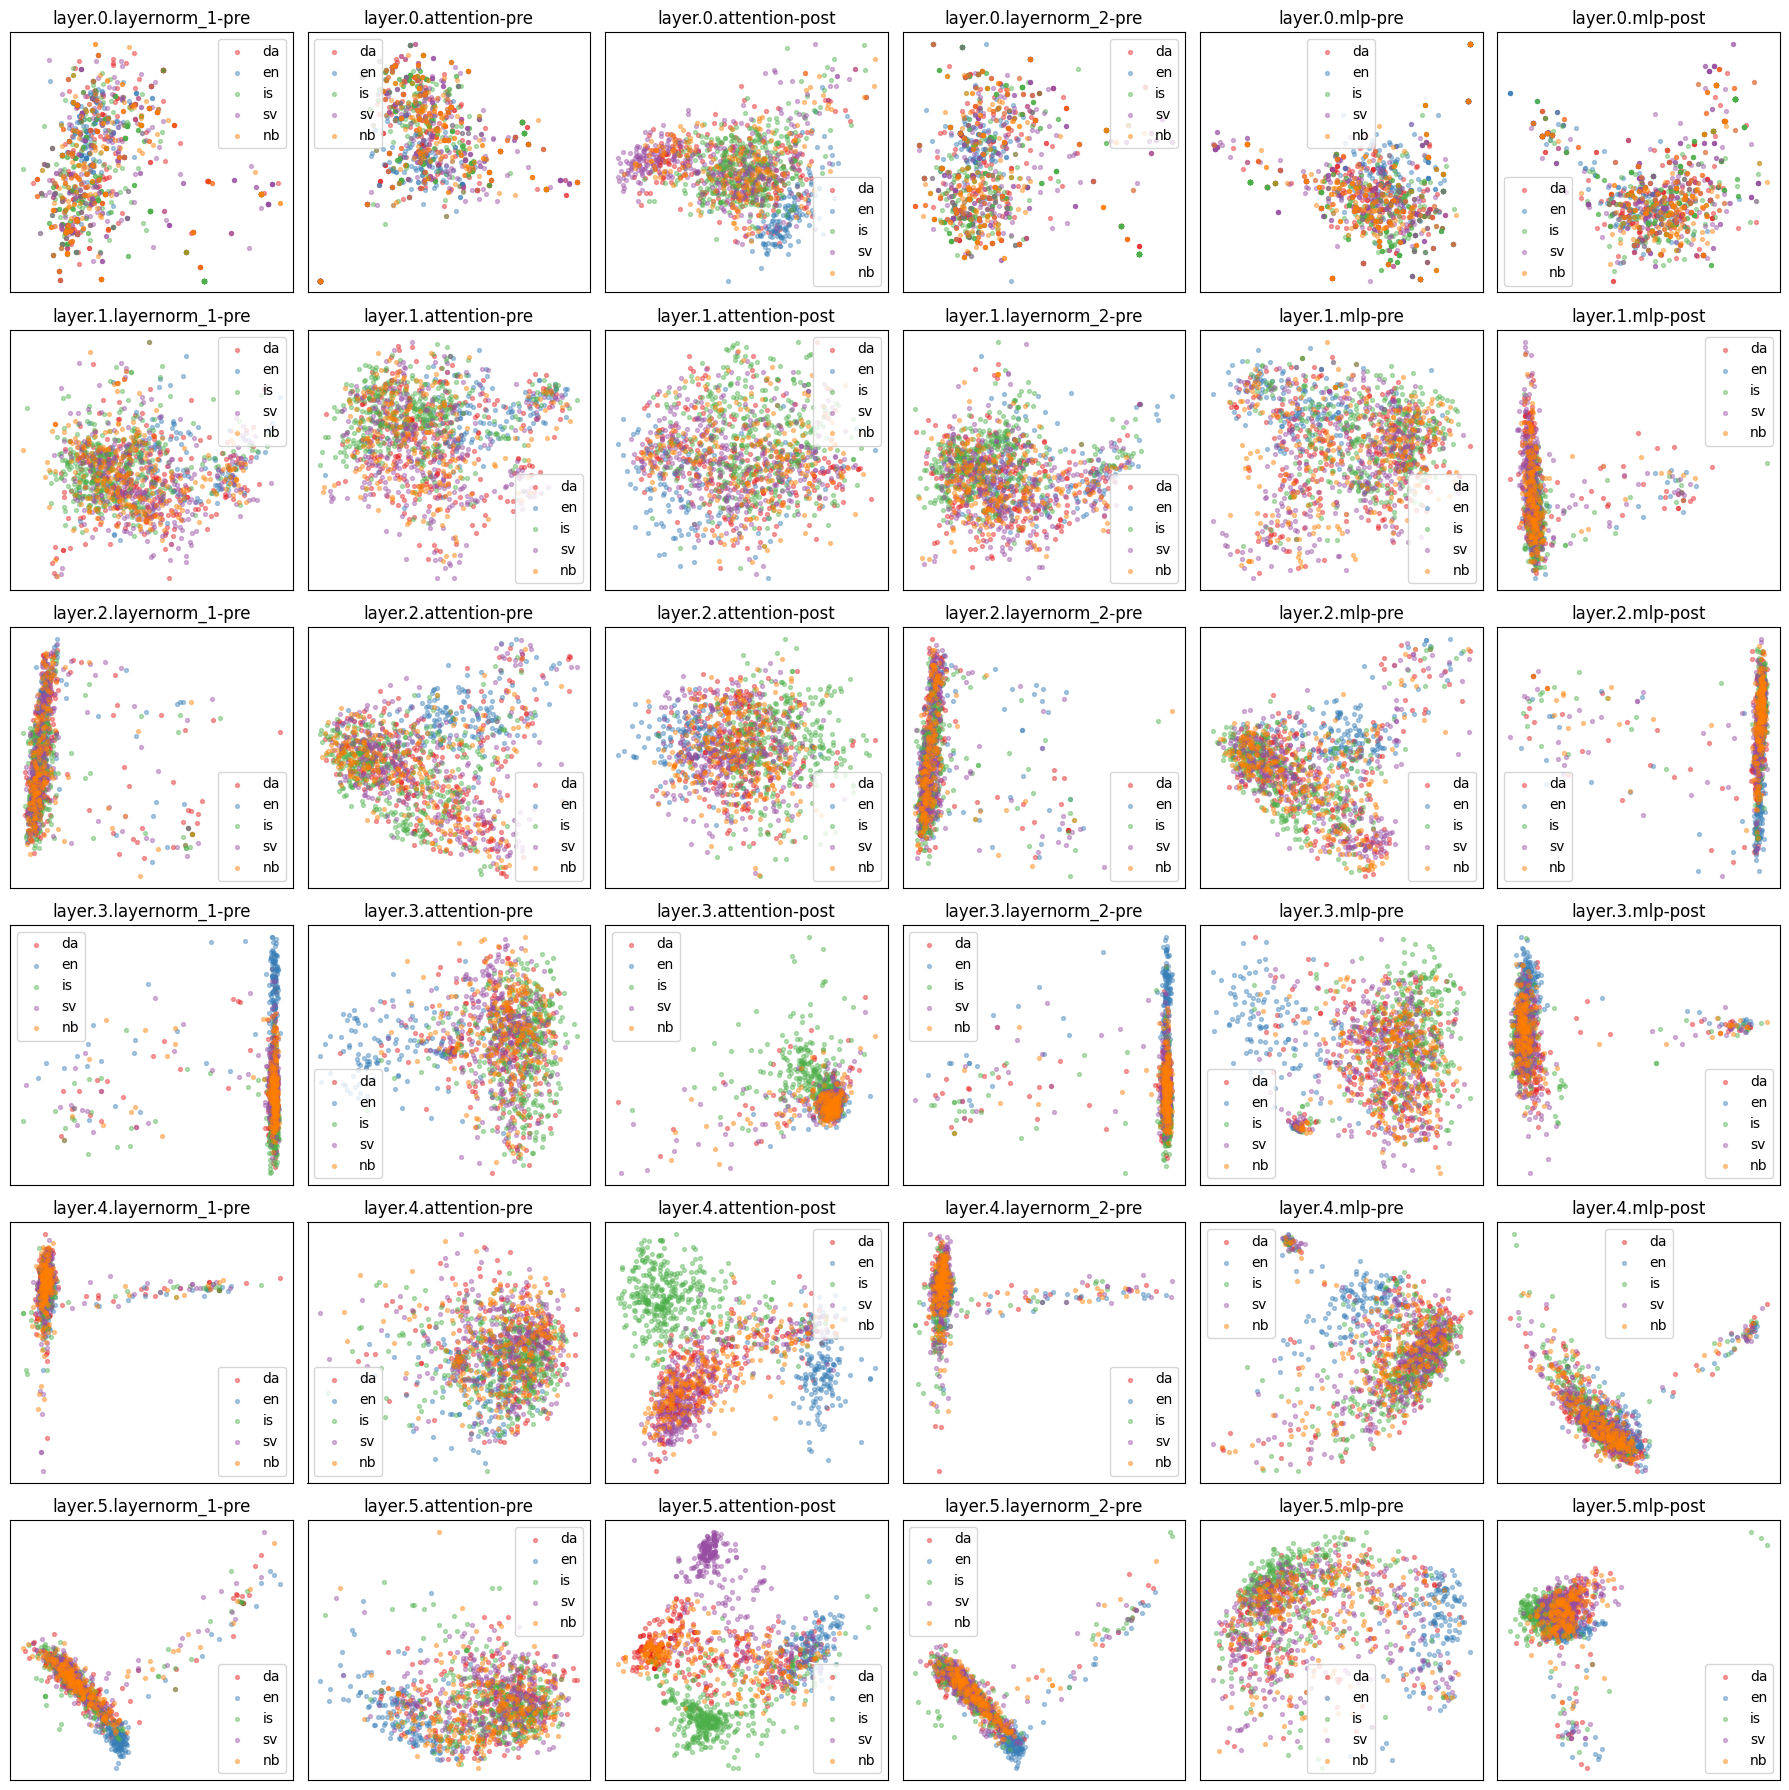

In [6]:
PCA.main(
    model_url=model_name,
    device=device,
    out_file='pythia.png'
)

### Distance Between Activations

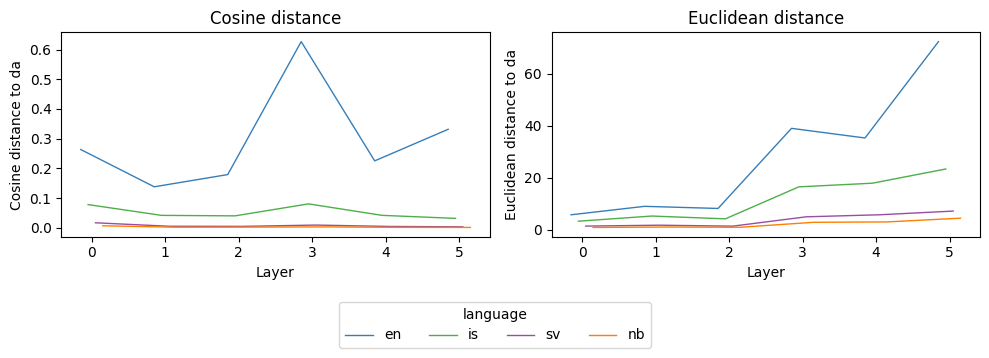

In [7]:
distance_plots.run(
    model_name_temp, 
    target,
    f"steering_vectors/average_activation_vectors/{model_name_temp}/",
    "cosine"
)

### Classification Probes

In [8]:
if compute:
    probe_confidence_intervals.run(
        model_name=model_name,
        reg_lambdas=[0.1, 0.5, 1, 2, 5, 10]
    )

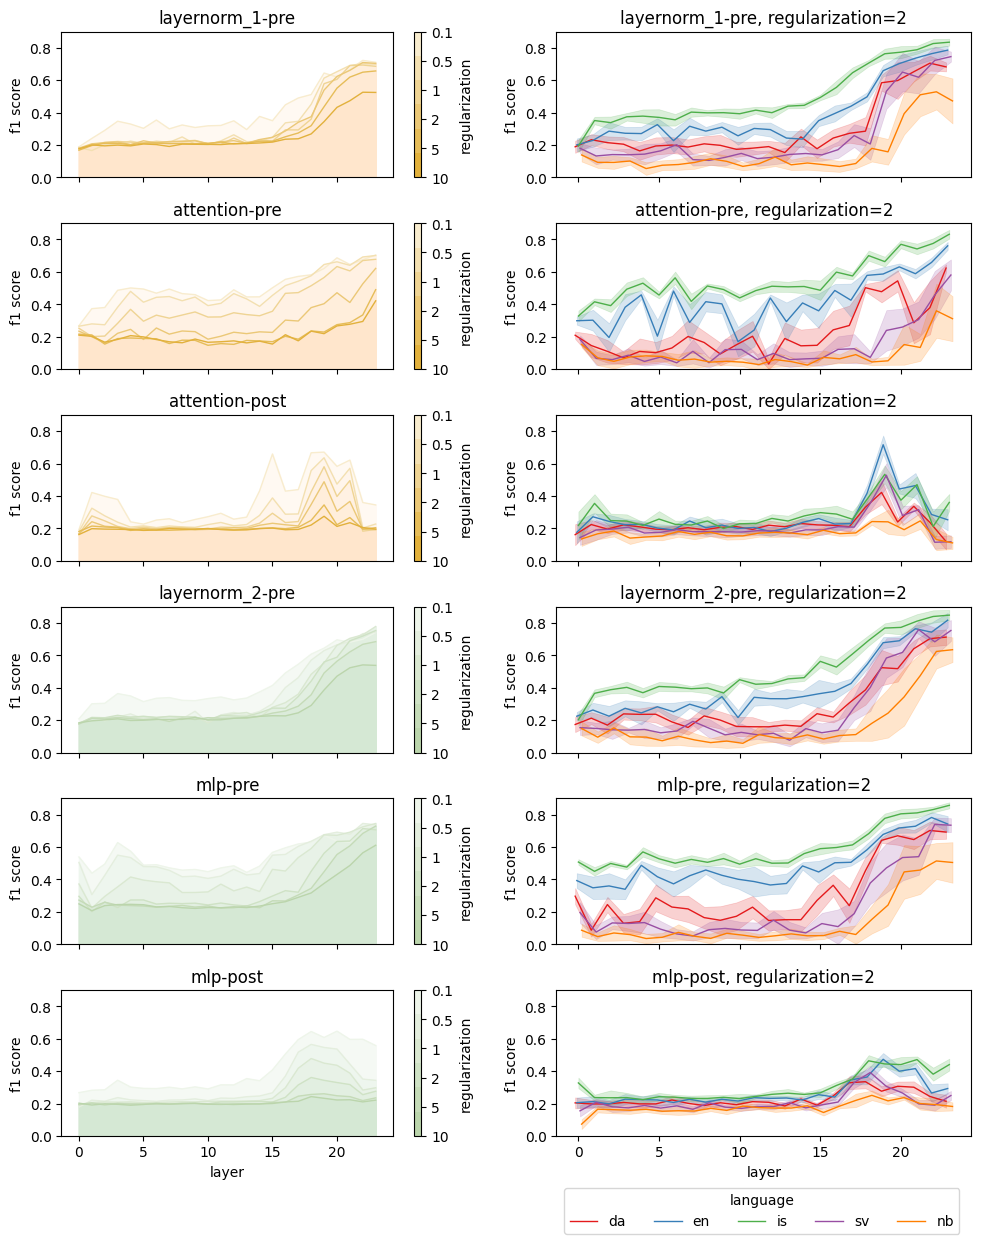

In [9]:
plot_probes.make_big_plot()

### Outlier Neurons

In [10]:
if compute:
    create_neuron_contributions.main(model_name, model_name_temp,hook_points,24)

In [11]:
plot_outlier_neurons.main(24,hook_points, model_name_temp)

FileNotFoundError: [Errno 2] No such file or directory: 'results/data/outlier_neurons/common_indices/pythia_14m.pkl'

## Representation Control

In [12]:
if compute:
    make_steering_vectors.main(
        model_url=model_name,
        target_language=target,
        complement_languages=not_target_languages,
        device=device,
        out_folder='steering_vectors/steering_vectors'
    )

### Token Based Visualization of Steering Vectors

In [18]:
text = "The cat (Felis catus), also referred to as the domestic cat or house cat, is a small domesticated carnivorous mammal. It is the only domesticated species of the family Felidae. Advances in archaeology and genetics have shown that the domestication of the cat occurred in the Near East around 7500 BC."

text_visualization.main(model_name, model_name_temp,text,"da",15)

Load model
found device: cpu


AttributeError: ModuleList has no attribute `15`

In [ ]:
text = "The cat (Felis catus), also referred to as the domestic cat or house cat, is a small domesticated carnivorous mammal. It is the only domesticated species of the family Felidae. Advances in archaeology and genetics have shown that the domestication of the cat occurred in the Near East around 7500 BC."
for layer in range(24):
    text_visualization.main(model_name, model_name_temp,text,"en",layer)
text = "Tamkatten (Felis catus[1][2] eller Felis silvestris catus[3]) er et lille, tæmmet, kødædende pattedyr oftest med pels. Den kaldes huskat eller bare kat, når der ikke er grund til at skelne den fra andre kattedyr. Katten er værdsat af mennesker for dens selskab og evne til at jage mus og rotter. Mange huskatte bliver op mod 20 år gamle."
for layer in range(24):
    text_visualization.main(model_name, model_name_temp,text,"da",layer)

### Steering Loss

51it [02:47,  3.29s/it]


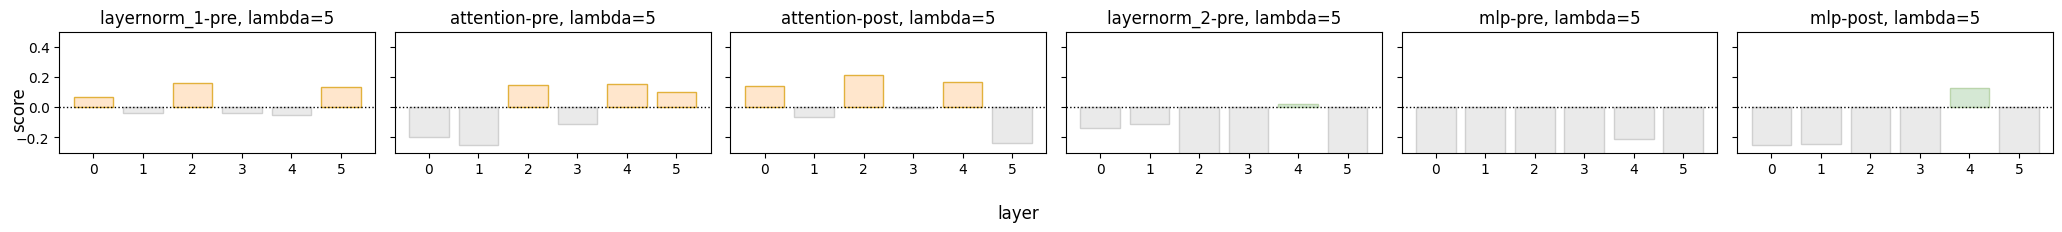

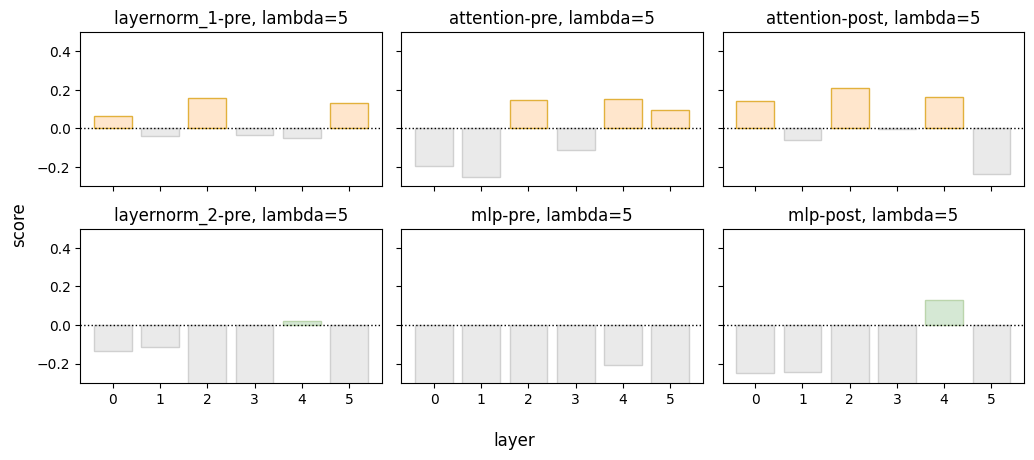

In [19]:
ds = load_bible_data('en', 'da')

model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

steering_loss.first_fig(
    model=model,
    tokenizer=tokenizer,
    shuffled_dataset=ds,
    out_file='results/figures/steering_loss/first_fig.png'
)

In [ ]:
steering_loss.plot_steering_vector_scores(
    model=model,
    tokenizer=tokenizer,
    ds=ds,
    steering_lambdas=[1,3,5,10,20],
    lan1='en',
    lan2='da',
    amount_datapoints=25,
    layers=None,
    hook_addresses=None,
    out_file='results/figures/steering_loss/big_fig.png'
)

### Bible Study

In [20]:
steering_vector_path = f"steering_vectors/steering_vectors/{model_name_temp}/"
model_name = model_name
language1 = "da"
language2 = "en"
start_verse = 0
end_verse = 285
lambda_search_space = [0]

if compute:
    create_bible_data.run(
        model_name,
        language1,
        language2, 
        steering_vector_path, 
        lambda_search_space, 
        start_verse,end_verse)

In [21]:
if compute:
    path = "results/data/steering_data_bible/"
    language_label = "__label__dan"
    process_bible_data.run(path, language_label)

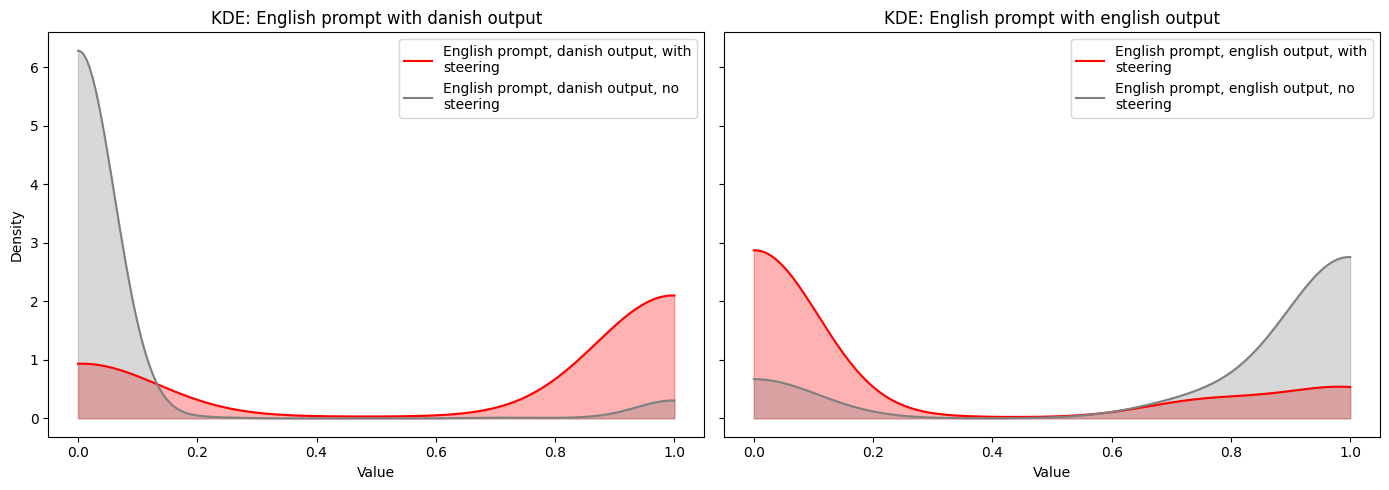

In [22]:
visualize_bible_study.run(
    file_path='results/data/steering_data_bible/bible_data_combined.csv',
    model_name_temp = model_name_temp
)

### Logit Lens

In [24]:
logit_lens.plot_logit_lens(
    model_url=model_name,
    device=device
)

AttributeError: GPTNeoXForCausalLM has no attribute `transformer`

In [25]:
logit_lens.plot_norm_of_logits(
    model_url=model_name,
    device=device
)

AttributeError: GPTNeoXForCausalLM has no attribute `transformer`

## Application

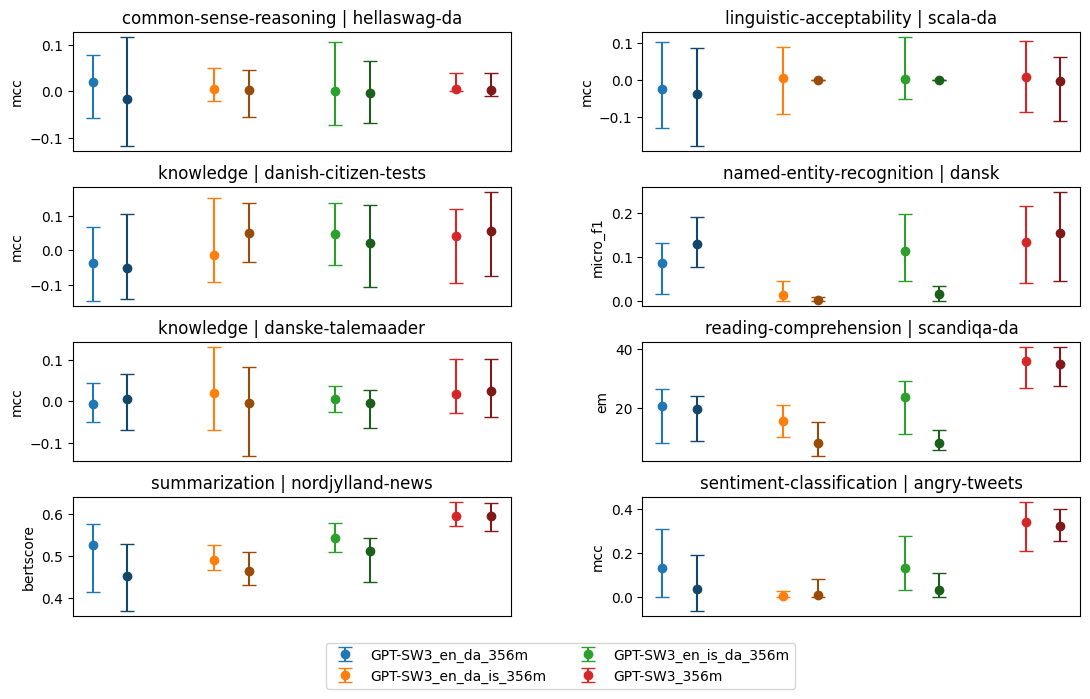

In [26]:
model_name_scandeval = ["gpt_sw3_356m","gpt_sw3_356m_with_steering_lambda_5",
                        "gpt_gptsw3_en_da_356m_gbs1024","gpt_gptsw3_en_da_356m_gbs1024_with_steering_lambda_5",
                        "gpt_gptsw3_en_is_da_356m_gbs1024","gpt_gptsw3_en_is_da_356m_gbs1024_with_steering_lambda_5",
                        "gpt_gptsw3_en_da_is_356m_gbs1024","gpt_gptsw3_en_da_is_356m_gbs1024_with_steering_lambda_5"]
df = scandeval_results.main("results/data/scandeval/scandeval_benchmark_results_den_gode.jsonl",model_name_scandeval)